In [211]:
import sys

sys.path.append("../")
import os
from pathlib import Path
from itertools import cycle
from typing import List

import numpy as np
from scipy import stats
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
import pandas as pd

from market.data import BatchData
from market.task import BayesianLinearRegression
from market.mechanism import BatchMarket
from market.policy import NllShapleyPolicy, SemivaluePolicy, ShapleyPolicy
from market.task import Task
from common.log import create_logger
from analytics.helpers import save_figure, get_pyplot_colors

class BanzhafPolicy(SemivaluePolicy):
    def __init__(
        self,
        active_agents: np.ndarray,
        baseline_agents: np.ndarray,
        polynomial_degree: int,
        regression_task: Task,
    ):
        super().__init__(
            active_agents=active_agents,
            baseline_agents=baseline_agents,
            polynomial_degree=polynomial_degree,
            regression_task=regression_task,
        )
        self._results = {}

    def _contribution_weight(self, *_) -> float:
        return 1 / (2 ** (len(self.active_agents) - 1))


class RobustShapley(ShapleyPolicy):
    def __init__(
        self,
        active_agents: np.ndarray,
        baseline_agents: np.ndarray,
        polynomial_degree: int,
        regression_task: Task,
    ):
        super().__init__(
            active_agents=active_agents,
            baseline_agents=baseline_agents,
            polynomial_degree=polynomial_degree,
            regression_task=regression_task,
        )
        self._results = {}
        self.median_coalition_size = 0.5 * (self.grand_coalition_size - 1)
        self.floor = np.math.floor(self.median_coalition_size)
        self.ceil = np.math.ceil(self.median_coalition_size)

    def _contribution_weight(self, coalition_size: int) -> float:
        if coalition_size >= self.floor:
            return super()._contribution_weight(coalition_size)
        return (
            super()._contribution_weight(coalition_size)
            * self.ceil
            * self.floor
            / np.math.factorial(coalition_size)
            / np.math.factorial(self.grand_coalition_size - coalition_size - 1)
        )


class NllBanzhafPolicy(NllShapleyPolicy):
    def __init__(
        self,
        active_agents: np.ndarray,
        baseline_agents: np.ndarray,
        polynomial_degree: int,
        regression_task: Task,
        observational: bool = True,
    ):
        super().__init__(
            active_agents=active_agents,
            baseline_agents=baseline_agents,
            polynomial_degree=polynomial_degree,
            regression_task=regression_task,
            observational=observational
        )
        self.observational = observational

    def _contribution_weight(self, *_) -> float:
        return 1 / (2 ** (len(self.active_agents) - 1))
    
class NllWeightedShapleyPolicy(NllShapleyPolicy):
    def __init__(
        self,
        active_agents: np.ndarray,
        baseline_agents: np.ndarray,
        polynomial_degree: int,
        regression_task: Task,
        observational: bool = True,
    ):
        super().__init__(
            active_agents=active_agents,
            baseline_agents=baseline_agents,
            polynomial_degree=polynomial_degree,
            regression_task=regression_task,
            observational=observational
        )
        self.median_coalition_size = 0.5 * (self.grand_coalition_size - 1)
        self.floor = np.math.floor(self.median_coalition_size)
        self.ceil = np.math.ceil(self.median_coalition_size)

    def _contribution_weight(self, coalition_size: int) -> float:
        if coalition_size >= self.floor:
            return super()._contribution_weight(coalition_size)
        return (
            super()._contribution_weight(coalition_size)
            * self.ceil
            * self.floor
            / np.math.factorial(coalition_size)
            / np.math.factorial(self.grand_coalition_size - coalition_size - 1)
        )
    
class NllPenalizedShapleyPolicy(NllShapleyPolicy):
    def __init__(
        self,
        active_agents: np.ndarray,
        baseline_agents: np.ndarray,
        polynomial_degree: int,
        regression_task: Task,
        observational: bool = True,
        alpha: float = np.log(2)
    ):
        super().__init__(
            active_agents=active_agents,
            baseline_agents=baseline_agents,
            polynomial_degree=polynomial_degree,
            regression_task=regression_task,
            observational=observational
        )
        self.alpha = alpha


    def _weighted_avg_contributions(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        contributions = super()._weighted_avg_contributions(X, y)

        def _calculate_penalties(X: np.ndarray):
            X_normalized = X / np.linalg.norm(X, axis=1, keepdims=True)
            similarity_matrix = np.dot(X_normalized, X_normalized.T)
            np.fill_diagonal(similarity_matrix, 0)
            support_agents = list(self.active_agents)
            return similarity_matrix.sum(axis=1)[support_agents]
        
        penalties = _calculate_penalties(X.T)
        return contributions * np.exp(-self.alpha * penalties)




        
    

In [405]:
sample_size = 10000
noise_variance = 0.5
regularization = 1e-5

num_replications = 5
c = np.eye(2+num_replications)
c[0, 1] = 0.97
c[1, 0] = 0.97
X = np.random.multivariate_normal(np.zeros(2+num_replications), c, size=sample_size)
X = np.column_stack((np.ones(len(X)), X))

for i in range(num_replications):
    X[:, -i-1] = X[:, 2] + np.random.normal(0, 0.2, size=sample_size)
y = 0.3 * X[:, 1] + 0.5 * X[:, 2] + 0.5 * X[:, 3] + np.random.normal(0, np.sqrt(noise_variance), size=sample_size)


allocation_a1_shapley_obs = np.zeros(num_replications+1)
allocation_a2_shapley_obs = np.zeros(num_replications+1)

allocation_a1_shapley_int = np.zeros(num_replications+1)
allocation_a2_shapley_int = np.zeros(num_replications+1)

allocation_a1_ban_obs = np.zeros(num_replications+1)
allocation_a2_ban_obs = np.zeros(num_replications+1)

allocation_a1_ban_int = np.zeros(num_replications+1)
allocation_a2_ban_int = np.zeros(num_replications+1)


allocation_a1_shapley_obs_penalized = np.zeros(num_replications+1)
allocation_a2_shapley_obs_penalized = np.zeros(num_replications+1)

allocation_a1_shapley_obs_weighted = np.zeros(num_replications+1)
allocation_a2_shapley_obs_weighted = np.zeros(num_replications+1)

for r in range(num_replications+1):
    market_data = BatchData(
            dummy_feature=X[:, 0:1],
            central_agent_features=X[:, 1:2],
            support_agent_features=X[:, 2:2+(2+r)],
            target_signal=y.reshape(-1, 1),
            polynomial_degree=1,
            test_frac=0.5,
        )
    
    observational = False
    task = BayesianLinearRegression(noise_variance=noise_variance, regularization=regularization)
    market = BatchMarket(market_data, regression_task=task, observational=observational)
    output = market.run(NllShapleyPolicy)
    allocation_a1_shapley_int[r] = output["train"]["allocations"][0]
    allocation_a2_shapley_int[r] = np.sum(output["train"]["allocations"][1:])

    observational = True
    task = BayesianLinearRegression(noise_variance=noise_variance, regularization=regularization)
    market = BatchMarket(market_data, regression_task=task, observational=observational)
    output = market.run(NllShapleyPolicy)
    allocation_a1_shapley_obs[r] = output["train"]["allocations"][0]
    allocation_a2_shapley_obs[r] = np.sum(output["train"]["allocations"][1:])

    observational = True
    task = BayesianLinearRegression(noise_variance=noise_variance, regularization=regularization)
    market = BatchMarket(market_data, regression_task=task, observational=observational)
    output = market.run(NllBanzhafPolicy)
    allocation_a1_ban_obs[r] = output["train"]["allocations"][0]
    allocation_a2_ban_obs[r] = np.sum(output["train"]["allocations"][1:])

    observational = False
    task = BayesianLinearRegression(noise_variance=noise_variance, regularization=regularization)
    market = BatchMarket(market_data, regression_task=task, observational=observational)
    output = market.run(NllBanzhafPolicy)
    allocation_a1_ban_int[r] = output["train"]["allocations"][0]
    allocation_a2_ban_int[r] = np.sum(output["train"]["allocations"][1:])

    observational = True
    task = BayesianLinearRegression(noise_variance=noise_variance, regularization=regularization)
    market = BatchMarket(market_data, regression_task=task, observational=observational)
    output = market.run(NllPenalizedShapleyPolicy)
    allocation_a1_shapley_obs_penalized[r] = output["train"]["allocations"][0]
    allocation_a2_shapley_obs_penalized[r] = np.sum(output["train"]["allocations"][1:])

    observational = True
    task = BayesianLinearRegression(noise_variance=noise_variance, regularization=regularization)
    market = BatchMarket(market_data, regression_task=task, observational=observational)
    output = market.run(NllWeightedShapleyPolicy)
    allocation_a1_shapley_obs_weighted[r] = output["train"]["allocations"][0]
    allocation_a2_shapley_obs_weighted[r] = np.sum(output["train"]["allocations"][1:])




    print(output["train"]["allocations"])



[0.47777612 0.52222388]
[0.23379167 0.29176445 0.09309765]
[0.17594144 0.24270961 0.05961355 0.0560414 ]
[0.12144219 0.18684951 0.03255307 0.03033469 0.02660923]
[0.08907116 0.14878733 0.01550816 0.0140047  0.0117066  0.01065066]
[0.08907116 0.14878733 0.01550816 0.0140047  0.0117066  0.01065066]


In [399]:
np.corrcoef(X[:, [1, 2]].T)

array([[1.       , 0.9703025],
       [0.9703025, 1.       ]])

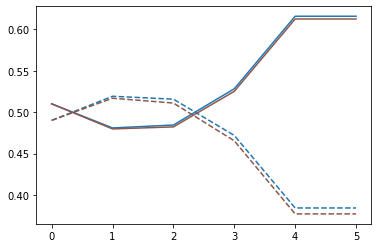

In [407]:
plt.plot(allocation_a1_shapley_int, color="C0", label="shapley-int")
plt.plot(allocation_a2_shapley_int, ls="dashed", color="C0")

# plt.plot(allocation_a1_shapley_obs, color="C1", label="shapley-obs")
# plt.plot(allocation_a2_shapley_obs, ls="dashed", color="C1")

# plt.plot(allocation_a1_ban_obs, color="C2", label="ban-obs")
# plt.plot(allocation_a2_ban_obs, ls="dashed", color="C2")

plt.plot(allocation_a1_ban_int, color="C5", label="ban-int")
plt.plot(allocation_a2_ban_int, ls="dashed", color="C5")

# plt.plot(allocation_a1_shapley_obs_penalized, color="C3", label="shapley-obs-penalized")
# plt.plot(allocation_a2_shapley_obs_penalized, ls="dashed", color="C3")

# plt.plot(allocation_a1_shapley_obs_weighted, color="C4", label="shapley-obs-weighted")
# plt.plot(allocation_a2_shapley_obs_weighted, ls="dashed", color="C4")

In [215]:
observational = True
task = BayesianLinearRegression(noise_variance=noise_variance, regularization=regularization)
market = BatchMarket(market_data, regression_task=task, observational=observational)
output = market.run(NllShapleyPolicy)
output["train"]

{'allocations': array([0.3464739 , 0.34962561, 0.30390049]),
 'contributions': array([0.17126948, 0.17282744, 0.15022453]),
 'payments': array([856.34738915, 864.13718863, 751.12264766])}

In [216]:
observational = True
task = BayesianLinearRegression(noise_variance=noise_variance, regularization=regularization)
market = BatchMarket(market_data, regression_task=task, observational=observational)
output = market.run(NllShapleyPolicy)
output["train"]

{'allocations': array([0.3464739 , 0.34962561, 0.30390049]),
 'contributions': array([0.17126948, 0.17282744, 0.15022453]),
 'payments': array([856.34738915, 864.13718863, 751.12264766])}

In [217]:
observational = True
task = BayesianLinearRegression(noise_variance=noise_variance, regularization=regularization)
market = BatchMarket(market_data, regression_task=task, observational=observational)
output = market.run(NllWeightedShapleyPolicy)
output["train"]

{'allocations': array([0.18272535, 0.18544115, 0.15257954]),
 'contributions': array([0.09032506, 0.09166754, 0.07542334]),
 'payments': array([451.62530561, 458.3376844 , 377.11668922])}

In [218]:
observational = True
task = BayesianLinearRegression(noise_variance=noise_variance, regularization=regularization)
market = BatchMarket(market_data, regression_task=task, observational=observational)
output = market.run(NllPenalizedShapleyPolicy)
output["train"]

{'allocations': array([0.0860523 , 0.08890228, 0.07729961]),
 'contributions': array([0.0425375 , 0.0439463 , 0.03821085]),
 'payments': array([212.68747606, 219.73152073, 191.0542695 ])}

In [219]:
observational = True
task = BayesianLinearRegression(noise_variance=noise_variance, regularization=regularization)
market = BatchMarket(market_data, regression_task=task, observational=observational)
output = market.run(NllBanzhafPolicy)
output["train"]

{'allocations': array([0.27104405, 0.27419576, 0.22847064]),
 'contributions': array([0.13398289, 0.13554085, 0.11293794]),
 'payments': array([669.91443369, 677.70423316, 564.68969219])}

In [200]:
observational = False
task = BayesianLinearRegression(noise_variance=noise_variance, regularization=regularization)
market = BatchMarket(market_data, regression_task=task, observational=observational)
output = market.run(NllShapleyPolicy)
output["train"]

{'allocations': array([ 0.57574018,  0.500804  , -0.07654418]),
 'contributions': array([ 0.29061629,  0.25279076, -0.03863719]),
 'payments': array([1453.08142508, 1263.95380883, -193.18597032])}

In [201]:
policy = NllShapleyPolicy(
    active_agents=market.market_data.active_agents,
            baseline_agents=market.market_data.baseline_agents,
            polynomial_degree=market.market_data.degree,
            regression_task=market.regression_task,
            observational=market.observational
)

In [168]:
np.array(list(market_data.active_agents))

array([2, 3, 4])

In [144]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(X.T)

array([[ 1.        , -0.00975065, -0.00854517, -0.00572124, -0.00880978],
       [-0.00975065,  1.        , -0.02762043, -0.03108824, -0.02736574],
       [-0.00854517, -0.02762043,  1.        ,  0.96951894,  0.96987784],
       [-0.00572124, -0.03108824,  0.96951894,  1.        ,  0.93992667],
       [-0.00880978, -0.02736574,  0.96987784,  0.93992667,  1.        ]])

In [208]:
def pairwise_cosine_similarity(X):
    """
    Calculate pairwise cosine similarities for a given numpy array.

    Parameters:
    - X: numpy array with shape (n_samples, n_features)

    Returns:
    - similarity_matrix: numpy array with pairwise cosine similarities
    """
    # Ensure that X is a 2D array
    if len(X.shape) != 2:
        raise ValueError("Input array must be 2D")

    # Calculate cosine similarities
    norm_X = np.linalg.norm(X, axis=1, keepdims=True)
    normalized_X = X / norm_X
    similarity_matrix = np.dot(normalized_X, normalized_X.T)

    return similarity_matrix

In [408]:
import cloudpickle

filename = "/Users/tdfalc/Projects/Research/regression-markets/analytics/docs/sim12-south-carolina/cache/_run_experiments_f744dd20.pkl"
with open(filename, "rb") as f:
    result = cloudpickle.load(f)

In [423]:
def add_replicate_revenue(values):
    values = values.copy()
    total = values[: max_reps + 1].sum()
    values = values[max_reps:]
    values[0] = total
    return values

all_allocations_names = {}
for name in result.keys():

    stage = "train"
    metric = "allocations"

    all_allocations = []

    allocations_before = result[name][0][stage][metric].flatten() * 100
    all_allocations.append(allocations_before)

    for max_reps in (1, 2, 3, 4, 5, 6):
        allocations_after = result[name][max_reps][stage][metric].flatten() * 100
        allocations_after_agg = add_replicate_revenue(allocations_after)
        all_allocations.append(allocations_after_agg)
    all_allocations = np.row_stack(all_allocations)

    all_allocations_names[name] = all_allocations

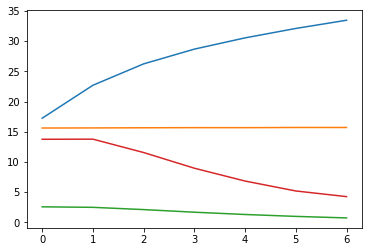

In [424]:
plt.plot(all_allocations_names["Shapley-Obs"][:, 0])
plt.plot(all_allocations_names["Shapley-Int"][:, 0])
plt.plot(all_allocations_names["Shapley-Obs-Penalized"][:, 0])
# plt.plot(all_allocations_names["Shapley-Obs-Weighted"][:, 0])
plt.plot(all_allocations_names["Banzhaf-Obs"][:, 0])



In [303]:
result["Shapley-Obs-Penalized"][0][stage][metric].flatten()

array([0.00400805, 0.0040458 , 0.00374712, 0.0030505 , 0.00335295,
       0.00166237])

In [329]:
np.exp(-0.4 * 10)

0.01831563888873418